In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import helper as h

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
import eli5
import re
from tqdm import tqdm

import gc

# Przygotowanie danych

In [2]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train['price_value'] = df_train["price_value"].map(h.parse_price)

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

df_train = df_train[ df_train.index != 106447 ].reset_index(drop=True)
df = pd.concat([df_train, df_test])
print(df.shape)

(80129, 10) (80129, 7)
(160257, 10)


In [3]:
if "Bezwypadkowy" not in df:
    params = df["offer_params"].apply(pd.Series)
    params = params.fillna(-1)
    
    df = pd.concat([df, params], axis=1)
    print(df.shape)
    
    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

(160257, 86)


['Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_cat',
 'VAT discount_cat'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160257 entries, 0 to 160254
Columns: 162 entries, id to Monthly payment value_cat
dtypes: float64(1), int64(77), object(84)
memory usage: 199.3+ MB


In [5]:
print(df.shape)
df.sample(5)

(160257, 162)


,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat
1512,2974,"Cena Brutto, Do negocjacji",11400.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Kraków, Małopolskie, Mistrzejowice","[Osobowe, Peugeot, 207]","{'Kolor': 'Biały', 'Model pojazdu': '207', 'Li...",Tak,5,Polska,1 398 cm3,Diesel,Manualna,-1,-1,Osoby prywatnej,3,209 000 km,-1,-1,Auta miejskie,Biały,207,Używane,Osobowe,-1,Na przednie koła,-1,2010,Peugeot,-1,15 marzec 2010,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,62,1,0,1,1,1,1,40,24,1,4,6,105,0,0,1,0,1,3,11,1,513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7156,7156,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Grand Auto Salon,Dealer,"Skrzatów 11 - 83-050 Kolbudy, gdański, Pomorsk...","[Osobowe, Audi, A8, Audi A8 D4 (2010-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",Tak,5,Niemcy,6 300 cm3,Benzyna,Automatyczna hydrauliczna (klasyczna),Tak,-1,Firmy,4,56 000 km,500 KM,Tak,Sedan,Szary,A8,Używane,Osobowe,Tak,4x4 (stały),Tak,2014,Audi,Tak,-1,Tak,-1,D4 (2010-),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,457,0,3,0,1,0,2,697,99,0,3,5,84,0,0,0,2,0,8,3,0,2,0,0,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10107,20209,"Cena Brutto, Do negocjacji",28500.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",AUTO-COM.S.C,Deal

In [6]:
df[cat_feats]

,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2,0,0,1,0,0,1,2,2,0,2,0,2,0,0,0,0,1,2,2,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,3,0,0,1,1,1,0,3,3,1,3,0,3,0,0,0,0,1,2,3,1,3,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,4,0,0,1,1,1,0,4,4,0,4,1,4,0,0,0,0,1,3,4,1,2,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160245,1,2,2,6,1,4,1,1,1,3,751,52,0,7,8,23,0,0,1,1,1,1,7,1,2,1,0,40,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160246,1,3,9,76,0,0,1,0,0,0,242,80,1,6,6,210,0,0,0,0,1,9,0,1,2,1,1,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160247,0,0,1,12,0,0,0,0,0,0,1679,30,0,4,8,39,0,0,0,0,1,6,2,1,2,1,1,39,35235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160251,1,0,7,25,1,0,1,1,1,0,457,70,1,4,6,105,0,0,1,0,1,3,11,1,1933,0,0,0,35236,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
feats_nunique = {feat:params[feat].nunique() for feat in params.columns}
{k: v for k, v in sorted(feats_nunique.items(), key=lambda item: item[1])}

{'Kategoria': 1,
 'Bezwypadkowy': 2,
 'Możliwość finansowania': 2,
 'Pierwszy właściciel': 2,
 'Oferta od': 2,
 'Stan': 2,
 'Serwisowany w ASO': 2,
 'Leasing': 2,
 'Faktura VAT': 2,
 'Zarejestrowany w Polsce': 2,
 'VAT marża': 2,
 'Perłowy': 2,
 'Uszkodzony': 2,
 'Filtr cząstek stałych': 2,
 'Tuning': 2,
 'Kierownica po prawej (Anglik)': 2,
 'Homologacja ciężarowa': 2,
 'Metallic': 2,
 'VAT discount': 2,
 'No accident': 2,
 'Service record': 2,
 'Acrylic': 2,
 'Financing option': 2,
 'Registered in Poland': 2,
 'Original owner': 2,
 'Pearl': 2,
 'Zarejestrowany jako zabytek': 2,
 'VAT free': 2,
 'Particle filter': 2,
 'Leasing concession': 2,
 'Damaged': 2,
 'Metalik': 3,
 'Akryl (niemetalizowany)': 3,
 'Matowy': 3,
 'Monthly payment value': 3,
 'Nr of seats': 4,
 'CO2 emissions': 4,
 'Door count': 5,
 'Fuel type': 5,
 'Skrzynia biegów': 6,
 'Napęd': 6,
 'Gearbox': 6,
 'Transmission': 6,
 'Rodzaj paliwa': 9,
 'Country of origin': 9,
 'Liczba miejsc': 10,
 'Body type': 10,
 'Liczba drzw

<AxesSubplot:>

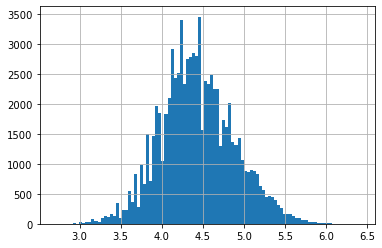

In [8]:
np.log10(df_train['price_value']).hist(bins=100)

## Dodatkowe cechy

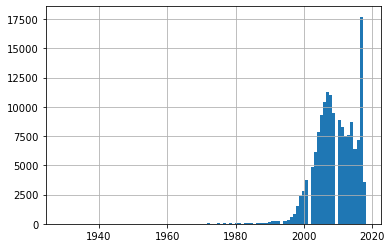

In [9]:
df["year_production"] = df["Rok produkcji"].astype(int)
df[ df["year_production"] != -1 ]["year_production"].hist(bins=100);

In [10]:
def reset_outliers(df, feat, prc=99):
    cut_value = np.percentile(df[feat].fillna(-1), prc)
    print(cut_value)
    return df[feat].fillna(-1).map(lambda x: x if x < cut_value else -1)

In [11]:
df['pojemnosc_skokowa'] = df["Pojemność skokowa"].str.replace(' ', '').str.replace('cm3', '').astype('float')
df[['pojemnosc_skokowa']].describe()

,pojemnosc_skokowa
count,152676.000
mean,2312.750
std,17216.196
min,1.000
25%,1560.000
50%,1896.000
75%,2000.000
max,3000218.000


6300.0
6300.0


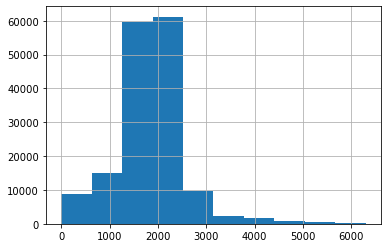

In [12]:
reset_outliers(df, 'pojemnosc_skokowa', 99.7).hist()
df['pojemnosc_skokowa99'] = reset_outliers(df, 'pojemnosc_skokowa', 99.7)

In [13]:
df[df['pojemnosc_skokowa'] > 50000][['pojemnosc_skokowa', "Pojemność skokowa"]]

,pojemnosc_skokowa,Pojemność skokowa
374,279300.000,279 300 cm3
2138,175300.000,175 300 cm3
2349,149800.000,149 800 cm3
3292,298700.000,298 700 cm3
3638,146100.000,146 100 cm3
...,...,...
152991,196800.000,196 800 cm3
154047,1896105.000,1 896 105 cm3
156276,189600.000,189 600 cm3
157054,195600.000,195 600 cm3


In [14]:
df[['pojemnosc_skokowa']].describe()

,pojemnosc_skokowa
count,152676.000
mean,2312.750
std,17216.196
min,1.000
25%,1560.000
50%,1896.000
75%,2000.000
max,3000218.000


array([[<AxesSubplot:title={'center':'moc_float'}>]], dtype=object)

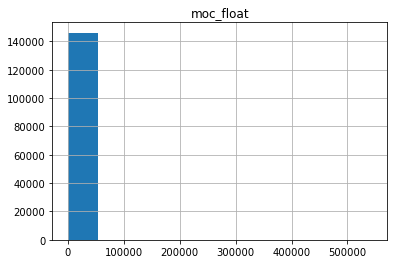

In [15]:
df['moc_float'] = df['Moc'].str.replace(' ', '').str.replace('KM', '').astype('float')
df[['moc_float']].hist()

585.0
585.0


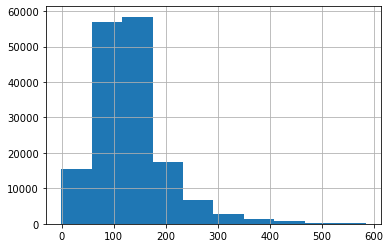

In [16]:
reset_outliers(df, 'moc_float', 99.8).hist()
df['moc99'] = reset_outliers(df, 'moc_float', 99.8)
# ['pojemnosc_skokowa99', 'moc99']

In [17]:
df.columns

Index(['id', 'price_details', 'price_value', 'price_currency', 'features',
       'seller_name', 'seller_type', 'seller_address', 'breadcrumb',
       'offer_params',
       ...
       'Particle filter_cat', 'Leasing concession_cat', 'Damaged_cat',
       'CO2 emissions_cat', 'Monthly payment value_cat', 'year_production',
       'pojemnosc_skokowa', 'pojemnosc_skokowa99', 'moc_float', 'moc99'],
      dtype='object', length=167)

In [18]:
df["breadcrumb_0"] = df["breadcrumb"].map(lambda x: x[0]).factorize()[0]
df["breadcrumb_1"] = df["breadcrumb"].map(lambda x: x[1]).factorize()[0]
df["breadcrumb_2"] = df["breadcrumb"].map(lambda x: x[2]).factorize()[0]
df["breadcrumb_3"] = df["breadcrumb"].map(lambda x: (x + ["N/A"])[3]).factorize()[0]

In [19]:
df['przebieg'] = df['Przebieg'].str.replace(' ', '').str.replace('km', '').astype('float')
df[['przebieg']].describe()

,przebieg
count,159723.000
mean,144489.570
std,124966.292
min,0.000
25%,69000.000
50%,154770.000
75%,205000.000
max,14600690.000


<AxesSubplot:>

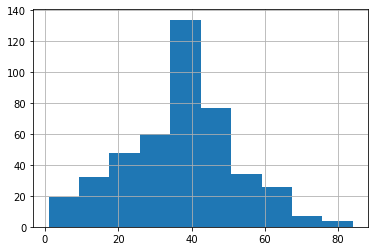

In [20]:
df['liczba_pozostalych_rat'] = df['Liczba pozostałych rat'].str.replace('3 482,92','-1').str.replace('8 926','-1').fillna('-1').astype('float')
df[df['liczba_pozostalych_rat']>0]['liczba_pozostalych_rat'].hist()

<AxesSubplot:>

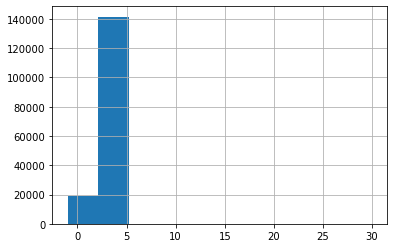

In [21]:
df['liczba_drzwi'] = df['Liczba drzwi'].astype(int)
df['liczba_drzwi'].hist()

7.0
7.0


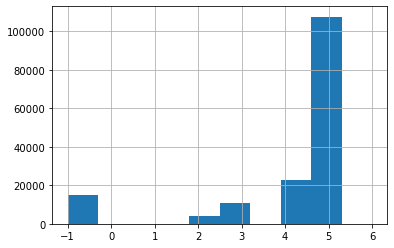

In [22]:
reset_outliers(df, 'liczba_drzwi', 99.99).hist()
df['liczba_drzwi99'] = reset_outliers(df, 'liczba_drzwi', 99.99)

<AxesSubplot:>

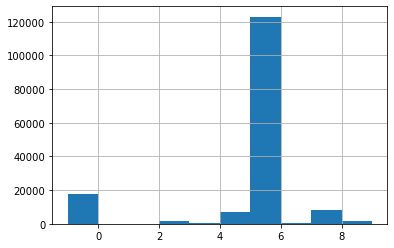

In [23]:
df['liczba_miejsc'] = df['Liczba miejsc'].astype(int)
df['liczba_miejsc'].hist()

In [24]:
# Starter 5
df["year_production"] = df["Rok produkcji"].astype(int)
df["year_production_ext"] = df.apply(lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1)

df["version_years"] = df["Wersja"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

<AxesSubplot:>

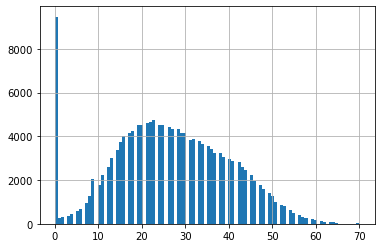

In [25]:
df['features_count'] = df['features'].map(lambda x: len(x))
df['features_count'].hist(bins=100)

In [26]:
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

def boolean_df(item_lists, unique_items):  # dzięki Ela :)
    bool_dict = {}
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

In [27]:
unique_features = list(set(to_1D(df["features"]).values))
unique_features

['Bluetooth',
 'Hak',
 'Tuner TV',
 'Radio fabryczne',
 'Szyberdach',
 'Centralny zamek',
 'Wielofunkcyjna kierownica',
 'Światła do jazdy dziennej',
 'Kamera cofania',
 'Asystent parkowania',
 'Światła przeciwmgielne',
 'Tapicerka welurowa',
 'System Start-Stop',
 'Czujniki parkowania tylne',
 'Regulowane zawieszenie',
 'Alarm',
 'Czujnik martwego pola',
 'Czujniki parkowania przednie',
 'Elektrycznie ustawiane lusterka',
 'Klimatyzacja czterostrefowa',
 'Światła LED',
 'Zmieniarka CD',
 'Podgrzewana przednia szyba',
 'Elektryczne szyby tylne',
 'ASR (kontrola trakcji)',
 'Tapicerka skórzana',
 'Podgrzewane tylne siedzenia',
 'Asystent pasa ruchu',
 'Klimatyzacja dwustrefowa',
 'Elektrochromatyczne lusterko wsteczne',
 'Światła Xenonowe',
 'Poduszki boczne przednie',
 'Dach panoramiczny',
 'CD',
 'Poduszki boczne tylne',
 'Poduszka powietrzna kierowcy',
 'Kurtyny powietrzne',
 'Przyciemniane szyby',
 'Gniazdo SD',
 'Elektrycznie ustawiane fotele',
 'Tempomat',
 'Immobilizer',
 'Elektr

In [28]:
feats_bool = boolean_df(df['features'], unique_features).astype(int)
feats_bool

,Bluetooth,Hak,Tuner TV,Radio fabryczne,Szyberdach,Centralny zamek,Wielofunkcyjna kierownica,Światła do jazdy dziennej,Kamera cofania,Asystent parkowania,Światła przeciwmgielne,Tapicerka welurowa,System Start-Stop,Czujniki parkowania tylne,Regulowane zawieszenie,Alarm,Czujnik martwego pola,Czujniki parkowania przednie,Elektrycznie ustawiane lusterka,Klimatyzacja czterostrefowa,Światła LED,Zmieniarka CD,Podgrzewana przednia szyba,Elektryczne szyby tylne,ASR (kontrola trakcji),Tapicerka skórzana,Podgrzewane tylne siedzenia,Asystent pasa ruchu,Klimatyzacja dwustrefowa,Elektrochromatyczne lusterko wsteczne,Światła Xenonowe,Poduszki boczne przednie,Dach panoramiczny,CD,Poduszki boczne tylne,Poduszka powietrzna kierowcy,Kurtyny powietrzne,Przyciemniane szyby,Gniazdo SD,Elektrycznie ustawiane fotele,Tempomat,Immobilizer,Elektrochromatyczne lusterka boczne,Alufelgi,Klimatyzacja automatyczna,Klimatyzacja manualna,Radio niefabryczne,Wspomaganie kierownicy,Isofix,Odtwarzacz DVD,Poduszka powietrzna chroniąca kolana,Nawigacja GPS,Podgrzewane przednie siedzenia,HUD (wyświetlacz przezierny),Czujnik deszczu,Łopatki zmiany biegów,ABS,Gniazdo AUX,Relingi dachowe,Czujnik zmierzchu,Elektryczne szyby przednie,Komputer pokładowy,Ogranicznik prędkości,Tempomat aktywny,Podgrzewane lusterka boczne,Ogrzewanie postojowe,ESP (stabilizacja toru jazdy),Poduszka powietrzna pasażera,MP3,Gniazdo USB
0,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,1
2,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,1,0
3,0,0,0,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0,1,1,1,0
4,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160245,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
160246,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1
160247,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0
160251,0,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0


In [29]:
df = pd.concat([df, feats_bool], axis=1)

In [30]:
# num = 777
# len(df2.loc[num]['features']), feats_bool.loc[num].sum()
# df2.loc[num]

In [31]:
# df[unique_features]

# Modele

## Procedury pomocnicze

In [32]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error", show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    df_test = df[ df["price_value"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price_value"]

    X_test = df_test[cat_feats]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X_train, y_train)
        print(result)
        return eli5.show_weights(model, feature_names=feats)
    
    return result

In [40]:
from sklearn.metrics import mean_absolute_error

def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error", show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    df_test = df[ df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)

    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)
    
    return result

## Sprawdzanie skuteczności posiadanych cech na podstawowych modelach

In [41]:
check_model(df, cat_feats, DecisionTreeRegressor(max_depth=5))

(19351.02073108123, 335.23734164964395)


Weight,Feature
0.4385,Faktura VAT_cat
0.3213,Rok produkcji_cat
0.1008,Napęd_cat
0.0983,Skrzynia biegów_cat
0.0367,Stan_cat
0.0019,Moc_cat
0.0015,Rodzaj paliwa_cat
0.0007,Typ_cat
0.0003,Uszkodzony_cat
0,Liczba pozostałych rat_cat


In [42]:
check_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(11051.872476848153, 311.19018814466676)


Weight,Feature
0.3143,Faktura VAT_cat
0.0886,Stan_cat
0.0731,Rok produkcji_cat
0.0702,Możliwość finansowania_cat
0.0676,Skrzynia biegów_cat
0.0507,Napęd_cat
0.0490,Serwisowany w ASO_cat
0.0341,Typ_cat
0.0266,Uszkodzony_cat
0.0236,Bezwypadkowy_cat


In [43]:
feats = ["year_production"] + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(9971.284857034767, 232.1370548676018)


Weight,Feature
0.3857,year_production
0.1660,Napęd_cat
0.0426,Skrzynia biegów_cat
0.0414,Uszkodzony_cat
0.0341,Serwisowany w ASO_cat
0.0253,Bezwypadkowy_cat
0.0243,Typ_cat
0.0218,Faktura VAT_cat
0.0209,Kierownica po prawej (Anglik)_cat
0.0207,Perłowy_cat


In [44]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float"] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8653.145285379189, 132.26707921529785)


Weight,Feature
0.4130,year_production
0.0939,moc_float
0.0844,Napęd_cat
0.0824,Skrzynia biegów_cat
0.0284,Uszkodzony_cat
0.0266,Bezwypadkowy_cat
0.0236,Serwisowany w ASO_cat
0.0211,Kierownica po prawej (Anglik)_cat
0.0202,Stan_cat
0.0173,pojemnosc_skokowa


In [45]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg"] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8578.018720432596, 211.0827331042081)


Weight,Feature
0.3550,year_production
0.1462,Skrzynia biegów_cat
0.0898,moc_float
0.0743,Napęd_cat
0.0406,Serwisowany w ASO_cat
0.0259,Uszkodzony_cat
0.0206,Kierownica po prawej (Anglik)_cat
0.0188,przebieg
0.0171,Bezwypadkowy_cat
0.0169,pojemnosc_skokowa


In [27]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat'] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8511.764710727988, 169.5005741348214)


Weight,Feature
0.3926,year_production
0.1245,Skrzynia biegów_cat
0.0902,moc_float
0.0655,Napęd_cat
0.0465,Serwisowany w ASO_cat
0.0248,Uszkodzony_cat
0.0205,przebieg
0.0203,Kierownica po prawej (Anglik)_cat
0.0195,Bezwypadkowy_cat
0.0166,pojemnosc_skokowa


In [28]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8481.092318011768, 198.10972760060835)


Weight,Feature
0.3731,year_production
0.1040,Skrzynia biegów_cat
0.0811,moc_float
0.0703,Napęd_cat
0.0624,Serwisowany w ASO_cat
0.0264,Uszkodzony_cat
0.0222,Możliwość finansowania_cat
0.0209,Kierownica po prawej (Anglik)_cat
0.0200,przebieg
0.0190,Bezwypadkowy_cat


In [46]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8354.442220718658, 214.34256060553813)


Weight,Feature
0.6667,year_production_ext
0.0520,Napęd_cat
0.0469,moc_float
0.0455,Skrzynia biegów_cat
0.0253,Serwisowany w ASO_cat
0.0124,Uszkodzony_cat
0.0115,przebieg
0.0115,Faktura VAT_cat
0.0114,Kierownica po prawej (Anglik)_cat
0.0099,pojemnosc_skokowa


In [49]:
h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8354.441846100193, 214.34261129882987)


Weight,Feature
0.6667,year_production_ext
0.0520,Napęd_cat
0.0469,moc_float
0.0455,Skrzynia biegów_cat
0.0253,Serwisowany w ASO_cat
0.0124,Uszkodzony_cat
0.0115,przebieg
0.0115,Faktura VAT_cat
0.0114,Kierownica po prawej (Anglik)_cat
0.0099,pojemnosc_skokowa


In [57]:
feats += ['features_count']

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8270.646084621478, 219.9056450894183)


Weight,Feature
0.6711,year_production_ext
0.0527,Skrzynia biegów_cat
0.0475,moc_float
0.0406,Napęd_cat
0.0263,features_count
0.0134,Uszkodzony_cat
0.0116,Serwisowany w ASO_cat
0.0109,przebieg
0.0107,Faktura VAT_cat
0.0101,Kierownica po prawej (Anglik)_cat


In [99]:
# powtorka po wycofaniu fillna(-1)
h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8270.646084621478, 219.9056450894183)


Weight,Feature
0.6711,year_production_ext
0.0527,Skrzynia biegów_cat
0.0475,moc_float
0.0406,Napęd_cat
0.0263,features_count
0.0134,Uszkodzony_cat
0.0116,Serwisowany w ASO_cat
0.0109,przebieg
0.0107,Faktura VAT_cat
0.0101,Kierownica po prawej (Anglik)_cat


In [125]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8241.545956526044, 153.5493741896514)


Weight,Feature
0.6243,year_production_ext
0.0545,moc_float
0.0409,Napęd_cat
0.0382,Skrzynia biegów_cat
0.0317,moc99
0.0222,features_count
0.0166,Serwisowany w ASO_cat
0.0147,Uszkodzony_cat
0.0134,przebieg
0.0117,Faktura VAT_cat


In [47]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))
# (8234.082681844271, 191.7024578599367)

(8234.267564814307, 191.60146070564016)


Weight,Feature
0.5356,year_production_ext
0.0479,moc_float
0.0425,Skrzynia biegów_cat
0.0338,Napęd_cat
0.0328,Faktura VAT_cat
0.0307,features_count
0.0305,Czujniki parkowania przednie
0.0224,moc99
0.0122,Uszkodzony_cat
0.0121,Światła LED


In [30]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features
# replikacja
h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8233.988855125563, 191.61668140765286)


Weight,Feature
0.5356,year_production_ext
0.0479,moc_float
0.0425,Skrzynia biegów_cat
0.0338,Napęd_cat
0.0328,Faktura VAT_cat
0.0308,features_count
0.0305,Czujniki parkowania przednie
0.0224,moc99
0.0122,Uszkodzony_cat
0.0121,Światła LED


## Zwiększanie głębokości oraz ilości estymatorów

In [29]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float"] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.3, random_state=0))

(8653.144895942376, 132.26751774732787)


Weight,Feature
0.4130,year_production
0.0939,moc_float
0.0844,Napęd_cat
0.0824,Skrzynia biegów_cat
0.0284,Uszkodzony_cat
0.0266,Bezwypadkowy_cat
0.0236,Serwisowany w ASO_cat
0.0211,Kierownica po prawej (Anglik)_cat
0.0202,Stan_cat
0.0173,pojemnosc_skokowa


In [30]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float"] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=400, learning_rate=0.1, random_state=0))

(8653.144895942376, 132.26751774732787)


Weight,Feature
0.4130,year_production
0.0939,moc_float
0.0844,Napęd_cat
0.0824,Skrzynia biegów_cat
0.0284,Uszkodzony_cat
0.0266,Bezwypadkowy_cat
0.0236,Serwisowany w ASO_cat
0.0211,Kierownica po prawej (Anglik)_cat
0.0202,Stan_cat
0.0173,pojemnosc_skokowa


In [31]:
breadcrumbs = ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats = ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] + breadcrumbs + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=400, learning_rate=0.3, random_state=0))

(8481.092318011768, 198.10972760060835)


Weight,Feature
0.3731,year_production
0.1040,Skrzynia biegów_cat
0.0811,moc_float
0.0703,Napęd_cat
0.0624,Serwisowany w ASO_cat
0.0264,Uszkodzony_cat
0.0222,Możliwość finansowania_cat
0.0209,Kierownica po prawej (Anglik)_cat
0.0200,przebieg
0.0190,Bezwypadkowy_cat


In [152]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=400, learning_rate=0.3, random_state=0))

(6812.679084537338, 171.9642774576824)


Weight,Feature
0.8090,year_production_ext
0.0205,Napęd_cat
0.0190,moc_float
0.0155,moc99
0.0074,breadcrumb_1
0.0071,Kierownica po prawej (Anglik)_cat
0.0068,Skrzynia biegów_cat
0.0058,Uszkodzony_cat
0.0056,Zarejestrowany jako zabytek_cat
0.0049,features_count


## Docelowy zestaw cech

In [49]:
%%time

feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"] # Dzień 1
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] # Dzień 1
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=1000, learning_rate=0.1, random_state=0))

(6212.971380549415, 192.22937988688707)
CPU times: user 1h 44min 38s, sys: 6.99 s, total: 1h 44min 45s
Wall time: 26min 20s


Weight,Feature
0.7973,year_production_ext
0.0213,Napęd_cat
0.0194,moc_float
0.0153,moc99
0.0087,Skrzynia biegów_cat
0.0086,Kierownica po prawej (Anglik)_cat
0.0055,Uszkodzony_cat
0.0055,Czujniki parkowania przednie
0.0050,breadcrumb_1
0.0046,Alufelgi


In [48]:
%%time

feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"] # Dzień 1
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] # Dzień 1
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=1000, learning_rate=0.1, random_state=0, colsample_bytree = 0.6))

(6186.610836235233, 156.83433819527846)
CPU times: user 1h 9min 45s, sys: 5.44 s, total: 1h 9min 51s
Wall time: 17min 34s


Weight,Feature
0.2313,year_production_ext
0.1442,Bluetooth
0.1117,year_production
0.0593,Napęd_cat
0.0473,Kamera cofania
0.0365,Faktura VAT_cat
0.0279,moc_float
0.0217,Kierownica po prawej (Anglik)_cat
0.0162,Czujniki parkowania tylne
0.0141,Czujniki parkowania przednie


In [50]:
%%time

feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"] # Dzień 1
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] # Dzień 1
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=2000, learning_rate=0.1, random_state=0, colsample_bytree = 0.6))

(6113.778595875172, 165.90723698082886)
CPU times: user 2h 16min 55s, sys: 9.29 s, total: 2h 17min 4s
Wall time: 34min 26s


Weight,Feature
0.2489,year_production_ext
0.1206,Bluetooth
0.1152,year_production
0.0586,Napęd_cat
0.0470,Kamera cofania
0.0334,Faktura VAT_cat
0.0294,Kierownica po prawej (Anglik)_cat
0.0264,moc_float
0.0135,Czujniki parkowania tylne
0.0133,Czujniki parkowania przednie


In [52]:
%%time

feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"] # Dzień 1
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc'] # Dzień 1
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']
feats += unique_features

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=7, n_estimators=4000, learning_rate=0.1, random_state=0, colsample_bytree = 0.6))

(6083.426909873245, 162.55317499310758)
CPU times: user 4h 19min 21s, sys: 14.8 s, total: 4h 19min 35s
Wall time: 1h 5min 8s


Weight,Feature
0.2661,year_production_ext
0.1169,year_production
0.0967,Bluetooth
0.0576,Napęd_cat
0.0409,Kierownica po prawej (Anglik)_cat
0.0359,Kamera cofania
0.0322,Faktura VAT_cat
0.0255,moc_float
0.0185,Zarejestrowany jako zabytek_cat
0.0152,Uszkodzony_cat


# Kaggle submission

## Procedury pomocnicze

In [33]:
def resplit(df, target):   
    df_train = df[ ~df[target].isnull() ].copy()
    df_test = df[ df[target].isnull() ].copy()

    print(df_train.shape, df_test.shape)
    return df_train, df_test

def prepare(df, features, target="price_value"):
    df_train, df_test = resplit(df, target)
    
    X_train = df_train[features]
    y_train = df_train[target]

    X_test = df_test[features]
    
    print(X_train.shape, y_train.shape, X_test.shape)
    return X_train, y_train, X_test

## Generowania pliku wynikowego

In [43]:
feats = cat_feats + ["breadcrumb_0", "breadcrumb_1", "breadcrumb_2", "breadcrumb_3"]  # Dzień 1
feats += ["year_production", "pojemnosc_skokowa", "moc_float", "przebieg", 'liczba_pozostalych_rat', 'liczba_drzwi', 'liczba_miejsc']  # Dzień 1
feats += ["year_production_ext", "version_year_from", "version_year_to"]  # Starter 5
feats += ['features_count']  # Dzień 2
feats += ['pojemnosc_skokowa99', 'moc99', 'liczba_drzwi99']  # Dzień 2
feats += unique_features  # Dzień 2

X_train, y_train, X_test = prepare(df, feats)

max_depth = 7
n_estimators = 4000
learning_rate = 0.1
model = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, random_state=0,
                        colsample_bytree = 0.6)

y_log = np.log(y_train)
model.fit(X_train, y_log)

# Sanity check
y_train_pred = np.exp(model.predict(X_train))
print(mean_absolute_error(y_train, y_train_pred))

y_pred = np.exp(model.predict(X_test))

df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_submission_8.csv", index=False)

eli5.show_weights(model, feature_names=feats)

(80128, 251) (80129, 251)
(80128, 164) (80128,) (80129, 164)
576.6726563965399


Weight,Feature
0.2608,year_production_ext
0.1195,year_production
0.1020,Bluetooth
0.0532,Napęd_cat
0.0387,Kierownica po prawej (Anglik)_cat
0.0360,Kamera cofania
0.0312,Faktura VAT_cat
0.0256,moc_float
0.0164,Uszkodzony_cat
0.0155,Liczba pozostałych rat_cat
